### plotting with seaborn
only use under analysis environment 

Basically everthing that needed to read/modify/write excel and plotting with sns

June update:
added section for generating excel files for averaged brains based on individual sample's excel

June 23 update:

    heatmaps:
    only include regions belonging to cerebrum, brain stem and cerebellum
    Include a threshold of 0.001 (0.1%) -> this threshold is not applied to isocortex only plot

In [1]:
import os
import numpy as np
import seaborn as sns

import pandas as pd
pd.options.mode.chained_assignment = None 
# disable the chained assignment warning

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

import itertools
# use itertool to flatten list of list

In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/','/512/']
    cc_cb_bs= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 and cerebellum  512 region only 
      
    new= cc_cb_bs.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_old(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def combine_df(folder,list_of_fname):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_df=[]
    
    for i in (list_of_fname):
        new_df=prep_df(os.path.join(folder, i))
        full_df.append(new_df)

    full_df=pd.concat(full_df,axis=1)
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    new= specific_df.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

# def combine_df_specific_new(folder,list_of_fname,region_id='', inner=False):
    
#     ''' !! Use this one becase combine_df_specific does not work in some cases which I havn't figured out why... 
#     combine multiple data frames, keeping only mouse name, region id and amount of voxels
#     by default, returns all of the regions that at least one brain that projects to it
#     region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''
    
#     full_df=pd.DataFrame(columns=['acronym'])
#     for i in list_of_fname:
#         this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id)
#         full_df=pd.merge(full_df,this_df,on='acronym', how='outer')
#     return full_df.set_index('acronym')

### Generate excel files for averaged brains based on excel file of each sample
with standard deviations

In [4]:
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [5]:
def average_excel(name_list, side, output_name):
    parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
    #change side to right for the other hemisphere!
    
    file_list=[]
    for i in name_list:
        contained = [x for x in parent_axons if i in x]
        file_list.append(contained[0])
    # extract all the file containing thesample name
    
    print('now processing the following files:')
    print(f'{file_list}')
    
    out_name=os.path.join(outdir,output_name)
    
    axonal_df= combine_df(folder, file_list)
    axonal_df=axonal_df.T
    
    y=axonal_df.index.to_list()
    test_order=[]

    for i in y:
        name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
        test_order.append(name)

    sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
    sort_acronym_df.sort_values('graph_order', inplace=True)
    # sort the aconnyms based on graph order

    final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
    #final_df
    
    final_df['average']=final_df.mean(axis=1)
    final_df['std']= final_df.std(axis=1)
    # compute average and std
    
    result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
    # need to reset_index here because acronym was both an index and a column
    
    result.to_excel(f'{out_name}_avg_{side}.xlsx') 
    
    return 


#### for s1 sim1 samples

In [29]:
region='s1'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL207','AL209','AL273']

##### left side - detialed code

In [24]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
#change side to right for the other hemisphere!

#name_list= ['AL207','AL209','AL273']

file_list=[]
for i in name_list:
    contained = [x for x in parent_axons if i in x]
    file_list.append(contained[0])
# extract all the file containing thesample name

file_list

out_name=os.path.join(outdir,'s1_sim')

In [8]:
axonal_df= combine_df(folder, file_list)
axonal_df=axonal_df.T

axonal_df.head()

# combine values from relevant samples based on acronym

,AL207,AL209,AL273
acronym,,,
fiber tracts,0.005841,0.001936,0.00355
RT,0.019293,0.00478,0.005749
VISal1,0.001994,0.000344,0.000134
ll,0.000155,0.000083,0.000156
MD,0.000292,0.00026,0.000875


In [9]:
y=axonal_df.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)
    
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on graph order

final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

In [15]:
final_df['average']=final_df.mean(axis=1)
final_df['std']= final_df.std(axis=1)
# compute average and std

In [18]:
result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
# need to reset_index here because acronym was both an index and a column
result.head()

# final result keeps all individual values but also computed average and std

,acronym,AL207,AL209,AL273,average,std,id,atlas_id,name,st_level,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
0,root,0.000642,0.000836,0.003453,0.001644,0.001282,997,-1.0,root,0,...,0,/997/,FFFFFF,NaN,NaN,f,1,385153371,734881840,root
1,FRP2/3,NaN,NaN,0.000004,0.000004,0.000000,667,1073.0,"Frontal pole, layer 2/3",11,...,8,/997/8/567/688/695/315/184/667/,268F45,NaN,NaN,f,9,4268100038,734881840,Frontal pole layer 2/3
2,FRP5,NaN,NaN,0.000075,0.000075,0.000000,526157192,NaN,"Frontal pole, layer 5",11,...,9,/997/8/567/688/695/315/184/526157192/,268F45,NaN,NaN,f,10,1413248090,734881840,Frontal pole layer 5
3,MOp1,0.000872,0.000001,0.001212,0.000695,0.000510,320,888.0,"Primary motor area, Layer 1",11,...,19,/997/8/567/688/695/315/500/985/320/,1F9D5A,NaN,NaN,f,20,571569106,734881840,Primary motor area Layer 1
4,MOp2/3,0.002361,0.000201,0.002009,0.001524,0.000946,943,966.0,"Primary motor area, Layer 2/3",11,...,20,/997/8/567/688/695/315/500/985/943/,1F9D5A,NaN,NaN,f,21,2488357079,734881840,Primary motor area Layer 2/3


In [19]:
result.to_excel(f'{out_name}_avg_{side}.xlsx') 
# save

##### right side 

In [38]:
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL207_axon_right_region_with_counts.xlsx', 'AL209_axon_right_region_with_counts.xlsx', 'AL273_axon_right_region_with_counts.xlsx']


#### for s2 sim1 samples

In [14]:
region='s2'
mouse_line= 'sim'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL281','AL286','AL321','AL322']

In [15]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL281_axon_left_region_with_counts.xlsx', 'AL286_axon_left_region_with_counts.xlsx', 'AL321_axon_left_region_with_counts.xlsx', 'AL322_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL281_axon_right_region_with_counts.xlsx', 'AL286_axon_right_region_with_counts.xlsx', 'AL321_axon_right_region_with_counts.xlsx', 'AL322_axon_right_region_with_counts.xlsx']


#### for s1 rbp samples

In [16]:
region='s1'
mouse_line= 'rbp'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL211','AL215','AL318']


In [17]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL211_axon_left_region_with_counts.xlsx', 'AL215_axon_left_region_with_counts.xlsx', 'AL318_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL211_axon_right_region_with_counts.xlsx', 'AL215_axon_right_region_with_counts.xlsx', 'AL318_axon_right_region_with_counts.xlsx']


#### for s2 rbp samples

In [18]:
region='s2'
mouse_line= 'rbp'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL288','AL326','AL327']

In [19]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL288_axon_left_region_with_counts.xlsx', 'AL326_axon_left_region_with_counts.xlsx', 'AL327_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL288_axon_right_region_with_counts.xlsx', 'AL326_axon_right_region_with_counts.xlsx', 'AL327_axon_right_region_with_counts.xlsx']


#### for s1 tlx samples

In [20]:
region='s1'
mouse_line= 'tlx'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL213','AL313','AL314']

In [21]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL213_axon_left_region_with_counts.xlsx', 'AL313_axon_left_region_with_counts.xlsx', 'AL314_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL213_axon_right_region_with_counts.xlsx', 'AL313_axon_right_region_with_counts.xlsx', 'AL314_axon_right_region_with_counts.xlsx']


#### for s2 tlx samples

In [22]:
region='s2'
mouse_line= 'tlx'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL278','AL280','AL319']

In [23]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL278_axon_left_region_with_counts.xlsx', 'AL280_axon_left_region_with_counts.xlsx', 'AL319_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL278_axon_right_region_with_counts.xlsx', 'AL280_axon_right_region_with_counts.xlsx', 'AL319_axon_right_region_with_counts.xlsx']


#### for s1 ras samples

In [24]:
region='s1'
mouse_line= 'ras'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL254','AL255','AL257']

In [25]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL254_axon_left_region_with_counts.xlsx', 'AL255_axon_left_region_with_counts.xlsx', 'AL257_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL254_axon_right_region_with_counts.xlsx', 'AL255_axon_right_region_with_counts.xlsx', 'AL257_axon_right_region_with_counts.xlsx']


#### for s2 ras samples

In [26]:
region='s2'
mouse_line= 'ras'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL303','AL332','AL333']

In [27]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL303_axon_left_region_with_counts.xlsx', 'AL332_axon_left_region_with_counts.xlsx', 'AL333_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL303_axon_right_region_with_counts.xlsx', 'AL332_axon_right_region_with_counts.xlsx', 'AL333_axon_right_region_with_counts.xlsx']


#### for s1 scn samples

In [28]:
region='s1'
mouse_line= 'scn'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL290','AL291','AL292','AL293']

In [29]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL290_axon_left_region_with_counts.xlsx', 'AL291_axon_left_region_with_counts.xlsx', 'AL292_axon_left_region_with_counts.xlsx', 'AL293_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL290_axon_right_region_with_counts.xlsx', 'AL291_axon_right_region_with_counts.xlsx', 'AL292_axon_right_region_with_counts.xlsx', 'AL293_axon_right_region_with_counts.xlsx']


#### for s2 scn samples

In [30]:
region='s2'
mouse_line= 'scn'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'
name_list= ['AL290','AL292','AL323']


In [31]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL290_axon_left_region_with_counts.xlsx', 'AL292_axon_left_region_with_counts.xlsx', 'AL323_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL290_axon_right_region_with_counts.xlsx', 'AL292_axon_right_region_with_counts.xlsx', 'AL323_axon_right_region_with_counts.xlsx']


#### for s1 nts samples

In [32]:
region='s1'
mouse_line= 'nts'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'

name_list= ['AL274','AL285','AL311']

In [33]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL285_axon_left_region_with_counts.xlsx', 'AL311_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL285_axon_right_region_with_counts.xlsx', 'AL311_axon_right_region_with_counts.xlsx']


#### for s2 nts samples

In [34]:
region='s2'
mouse_line= 'nts'

folder= f'D:\\viral_results\\{region}'
outdir = f'D:\\viral_results\\{region}_results'

outputname= f'{region}_{mouse_line}'


name_list= ['AL274','AL310','AL330']


In [35]:
average_excel(name_list, 'left', outputname)
average_excel(name_list, 'right', outputname)

now processing the following files:
['AL274_axon_left_region_with_counts.xlsx', 'AL310_axon_left_region_with_counts.xlsx', 'AL330_axon_left_region_with_counts.xlsx']
now processing the following files:
['AL274_axon_right_region_with_counts.xlsx', 'AL310_axon_right_region_with_counts.xlsx', 'AL330_axon_right_region_with_counts.xlsx']


###  heatmap for axons in brain region

LOG scale or linear scale

In [3]:
#find all relevant files
folder= r'D:\viral_results\s2'
outdir = r'D:\viral_results\s2_results'

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')


In [4]:
#column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

In [11]:
side='right'
parent_axons= [ i for i  in os.listdir(folder) if 'Rparent' in i]
#change side to right and Rparent for the other hemisphere!

#axonal_df= combine_df_old(folder, parent_axons)
#axonal_df=axonal_df.T

axonal_df= combine_df(folder, parent_axons)
#a cleaner way to concatenate dataframe


In [12]:
final=axonal_df[column_order]

df=final.fillna(0.0)
# fill Nan with 0 because sns heatmap does not accept nan


In [13]:
y=final.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)

# get all the acronyms involved and their graphorder

In [14]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on parent structure id

final_df= df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

In [44]:
#final_df[final_df.index=='SPVI']

In [15]:
final_df = final_df[(final_df > 0.001).any(1)]

# only take regions that have value above 0.01 for any one of the sample

final_df

,AL303,AL332,AL333,AL290,AL292,AL323,AL278,AL280,AL319,AL288,AL326,AL327,AL281,AL286,AL321,AL322,AL274,AL310,AL330
acronym,,,,,,,,,,,,,,,,,,,
FRP,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001961,0.000452,0.000504,0.002526,0.000479,0.000367,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MOp,0.000000,0.000000,0.000000,0.000000,0.000406,0.0,0.004636,0.003594,0.006544,0.007855,0.008630,0.005674,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MOs,0.000001,0.000000,0.000000,0.000000,0.000778,0.0,0.041477,0.019181,0.027962,0.034784,0.034433,0.018610,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
SSp-n,0.000000,0.000221,0.000119,0.002338,0.000000,0.0,0.000595,0.002318,0.002828,0.003436,0.002504,0.000423,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
SSp-bfd,0.038834,0.028861,0.006713,0.063443,0.000649,0.0,0.011421,0.022639,0.010526,0.012690,0.013034,0.004177,0.000042,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MARN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.001103,0.000603,0.000274,0.000588,0.000773,0.0,0.0,0.0,0.0,0.0
PARN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000810,0.002211,0.001964,0.002339,0.002018,0.0,0.0,0.0,0.0,0.0
PGRN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.001337,0.000988,0.000664,0.000123,0.000801,0.0,0.0,0.0,0.0,0.0


In [32]:
final_df.values.max()

0.07041043570152376

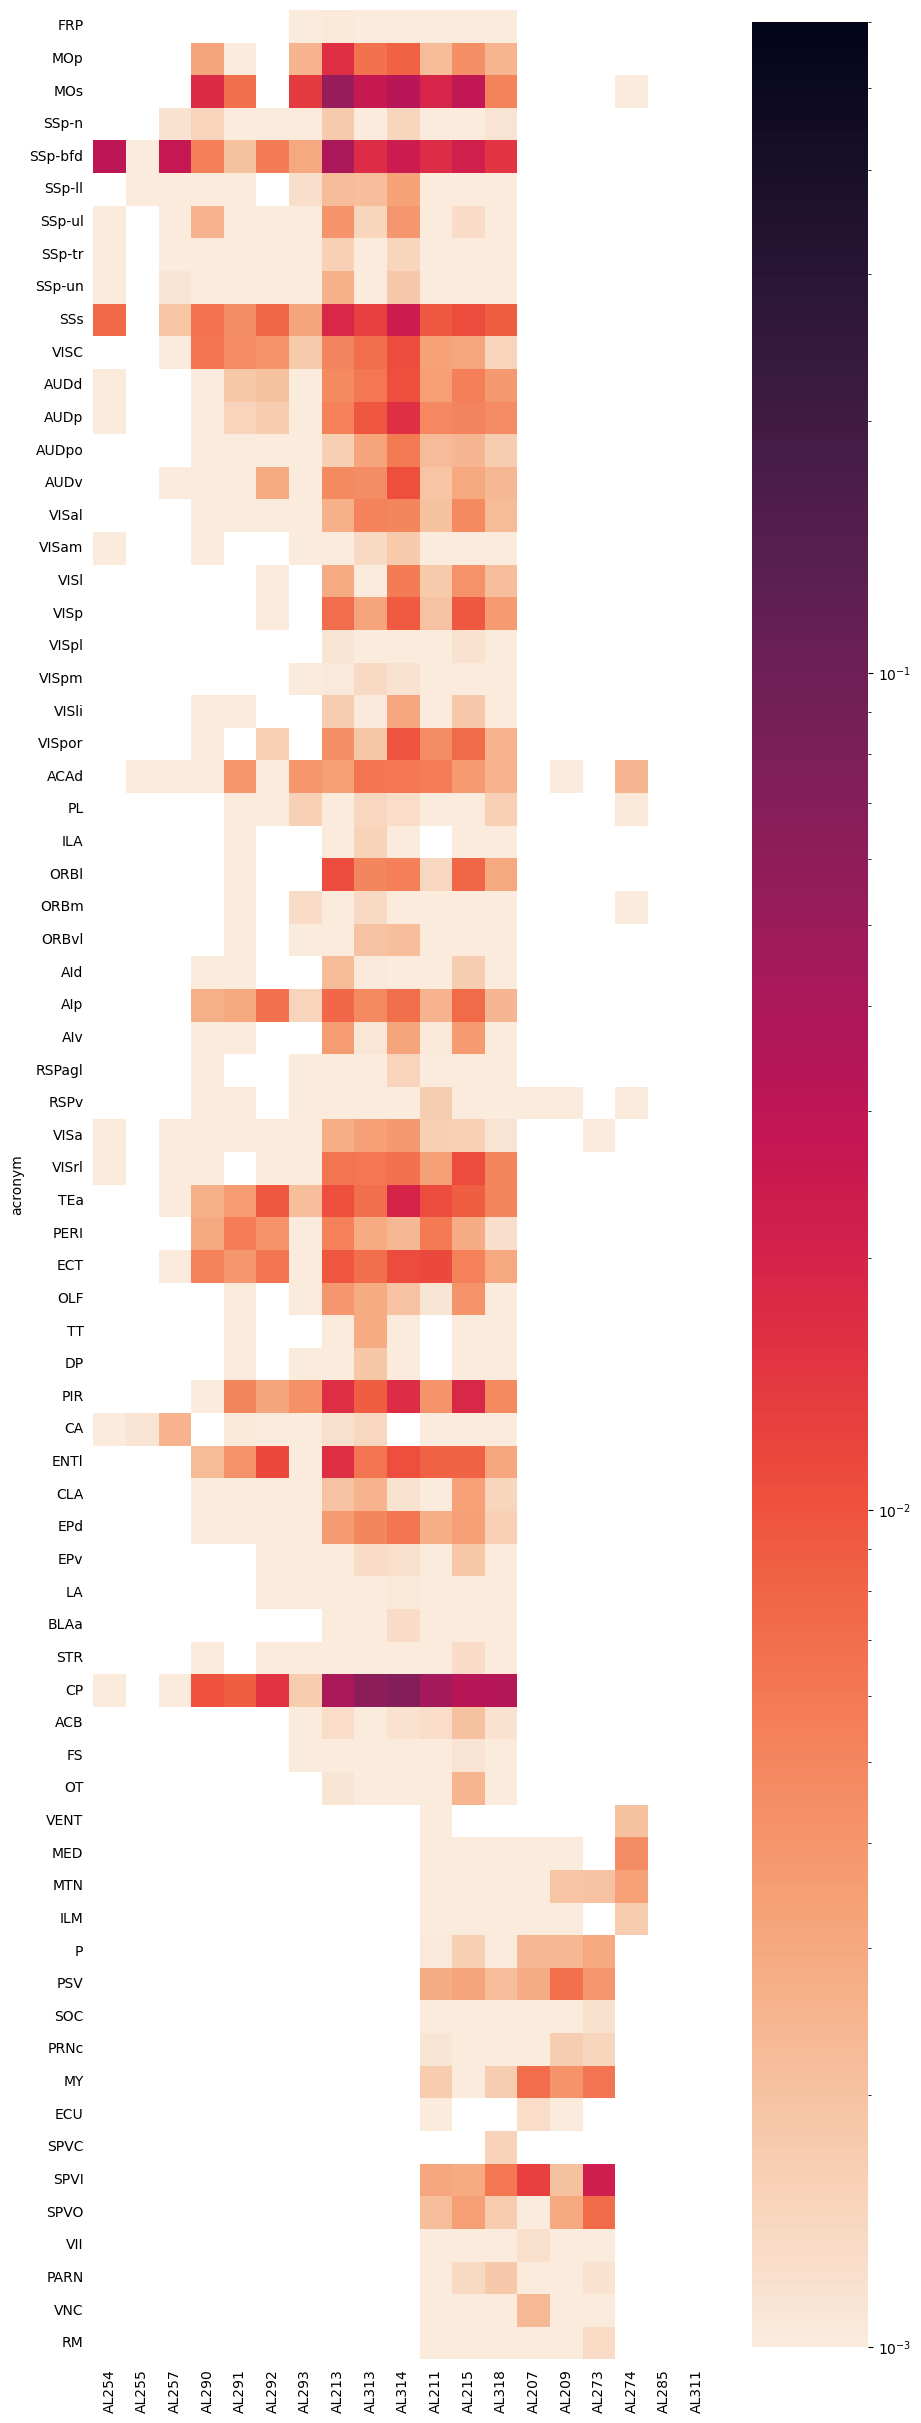

In [38]:
# log color scale, do not change vmin and vmax! 0.001 and 0.6

fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_df, 
                norm=LogNorm(vmin=0.001, vmax= 0.6),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

#plt.savefig(f'{outdir}\{side}_heatmap_logscale.svg')

#plt.show()

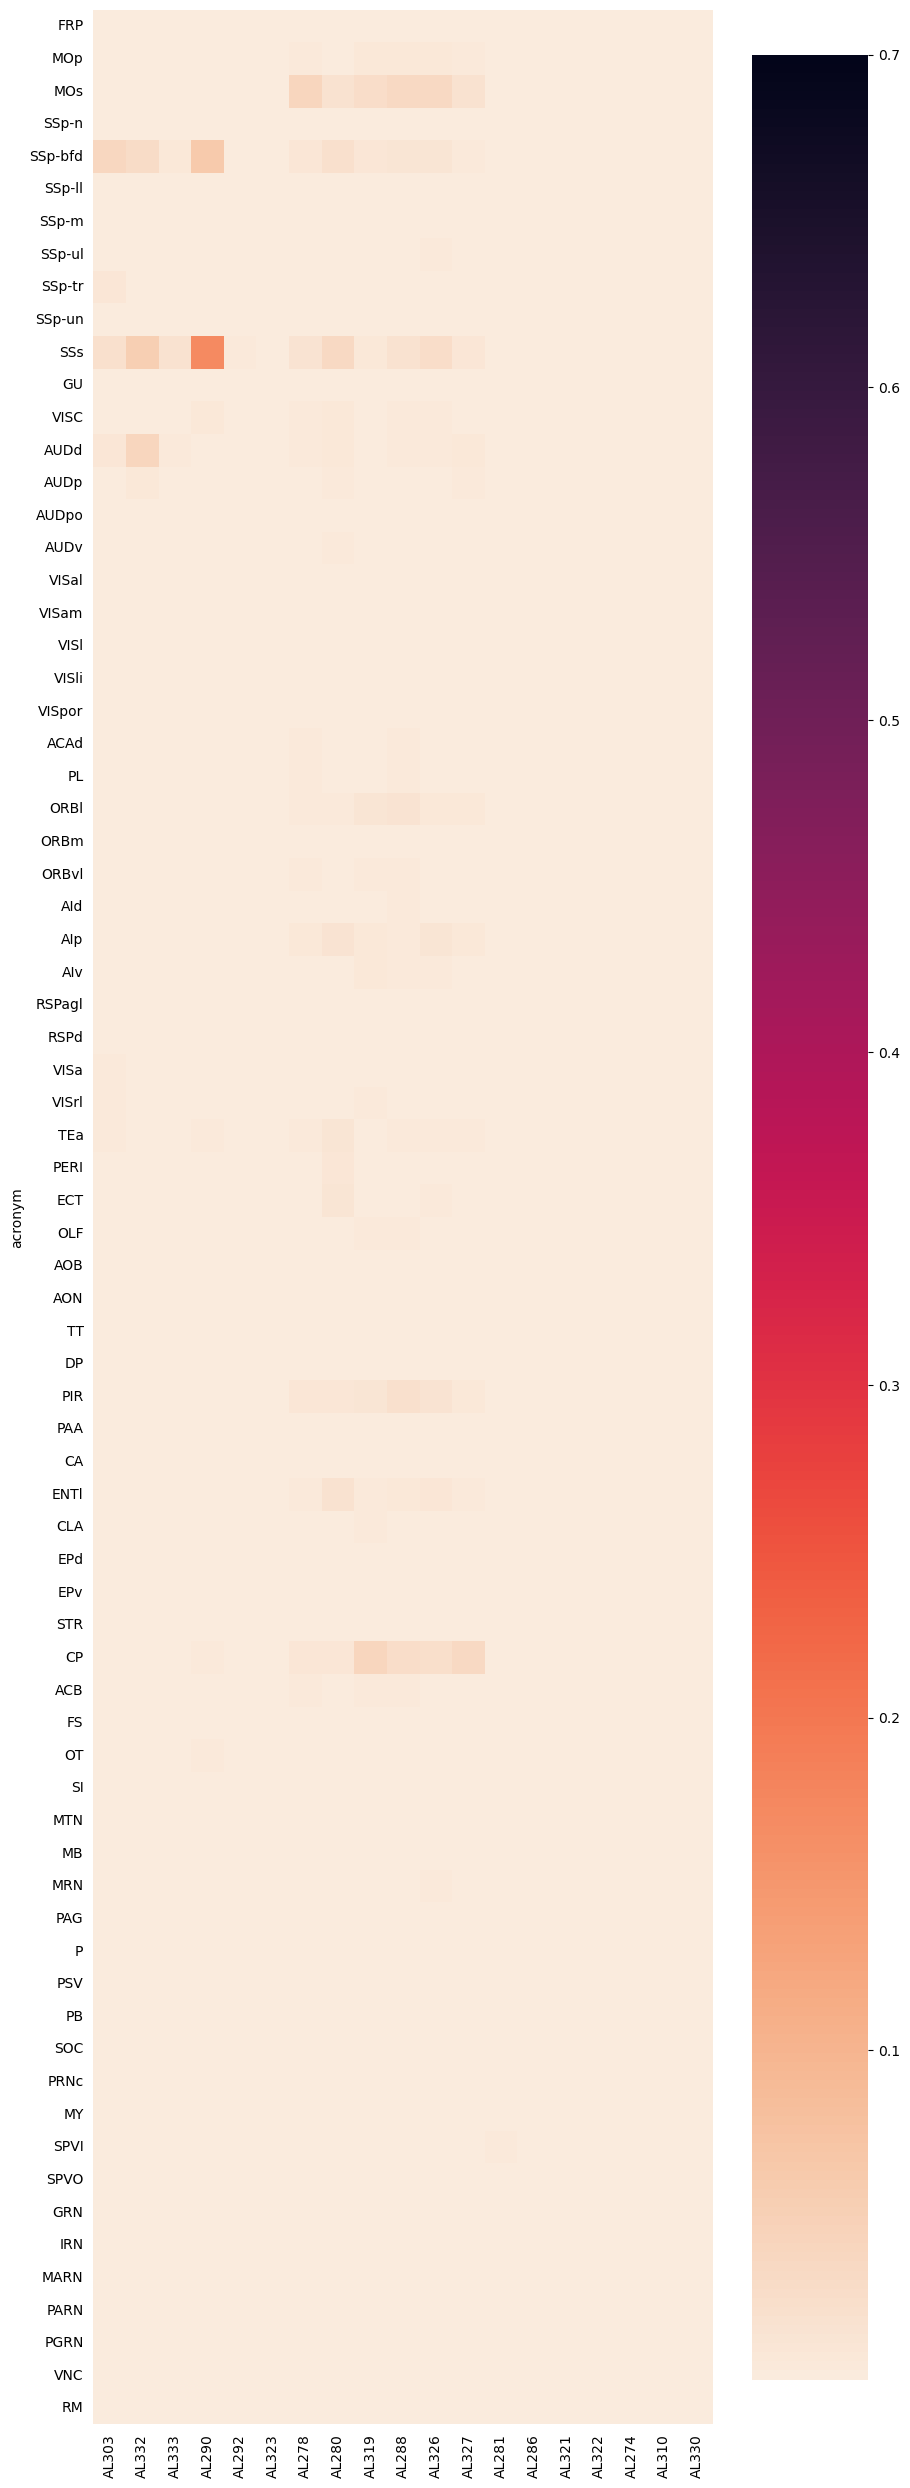

In [16]:
# linear scale, do not change vmin and vmax!! 0.001 and 0.7
fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_df, 
                cmap="rocket_r",
                square=True,
                vmin= 0.001,
                vmax=0.7, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\{side}_heatmap_linearscale.svg')

plt.show()

### heatmap for axons in brain region - isocortex only 
id= 315

In [24]:
#find all relevant files
folder= r'D:\viral_results\s2'
outdir = r'D:\viral_results\s2_results'

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [32]:
side='left'
parent_axons= [ i for i  in os.listdir(folder) if 'Lparent' in i]
#change side to right and Rparent for the other hemisphere!

In [33]:
# plot isocortex only 
region_id='315'
axonal_df= combine_df_specific(folder, parent_axons,region_id)
axonal_df=axonal_df.T

In [34]:
#column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327','AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of June.2023

final=axonal_df[column_order]

df=final.fillna(0.0)
# fill Nan with 0 because sns heatmap does not accept nan

In [35]:
y=final.index.to_list()
test_order=[]

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
    test_order.append(name)

# get all the acronyms involved and their graphorder

In [36]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
sort_acronym_df.sort_values('graph_order', inplace=True)
# sort the aconnyms based on parent structure id

final_df= df.reindex(sort_acronym_df.acronyms.to_list())
#final_df

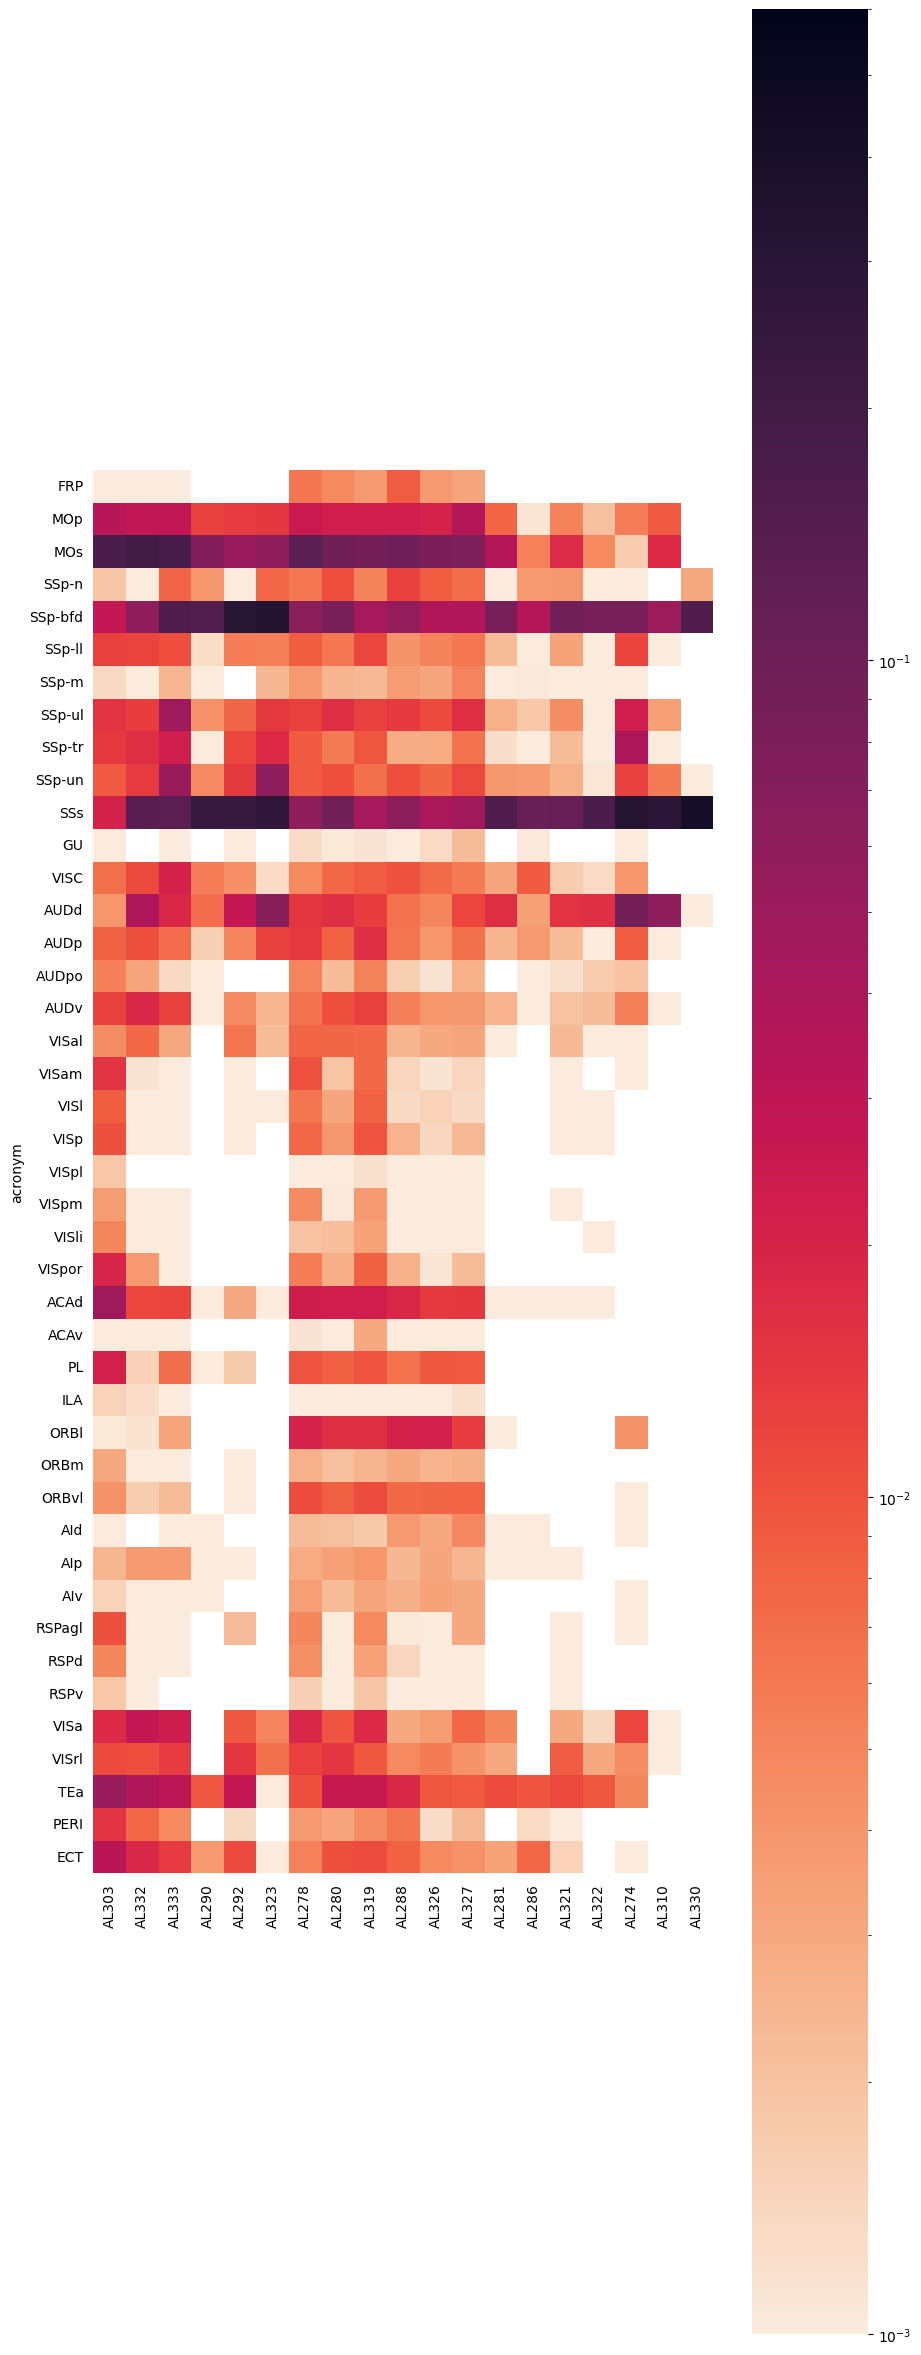

In [37]:
# log color scale, do not change vmin and vmax! 0.001 and 0.6

fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_df, 
                norm=LogNorm(vmin=0.001, vmax= 0.6),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\{side}_{region_id}_heatmap_logscale.svg')
plt.show()

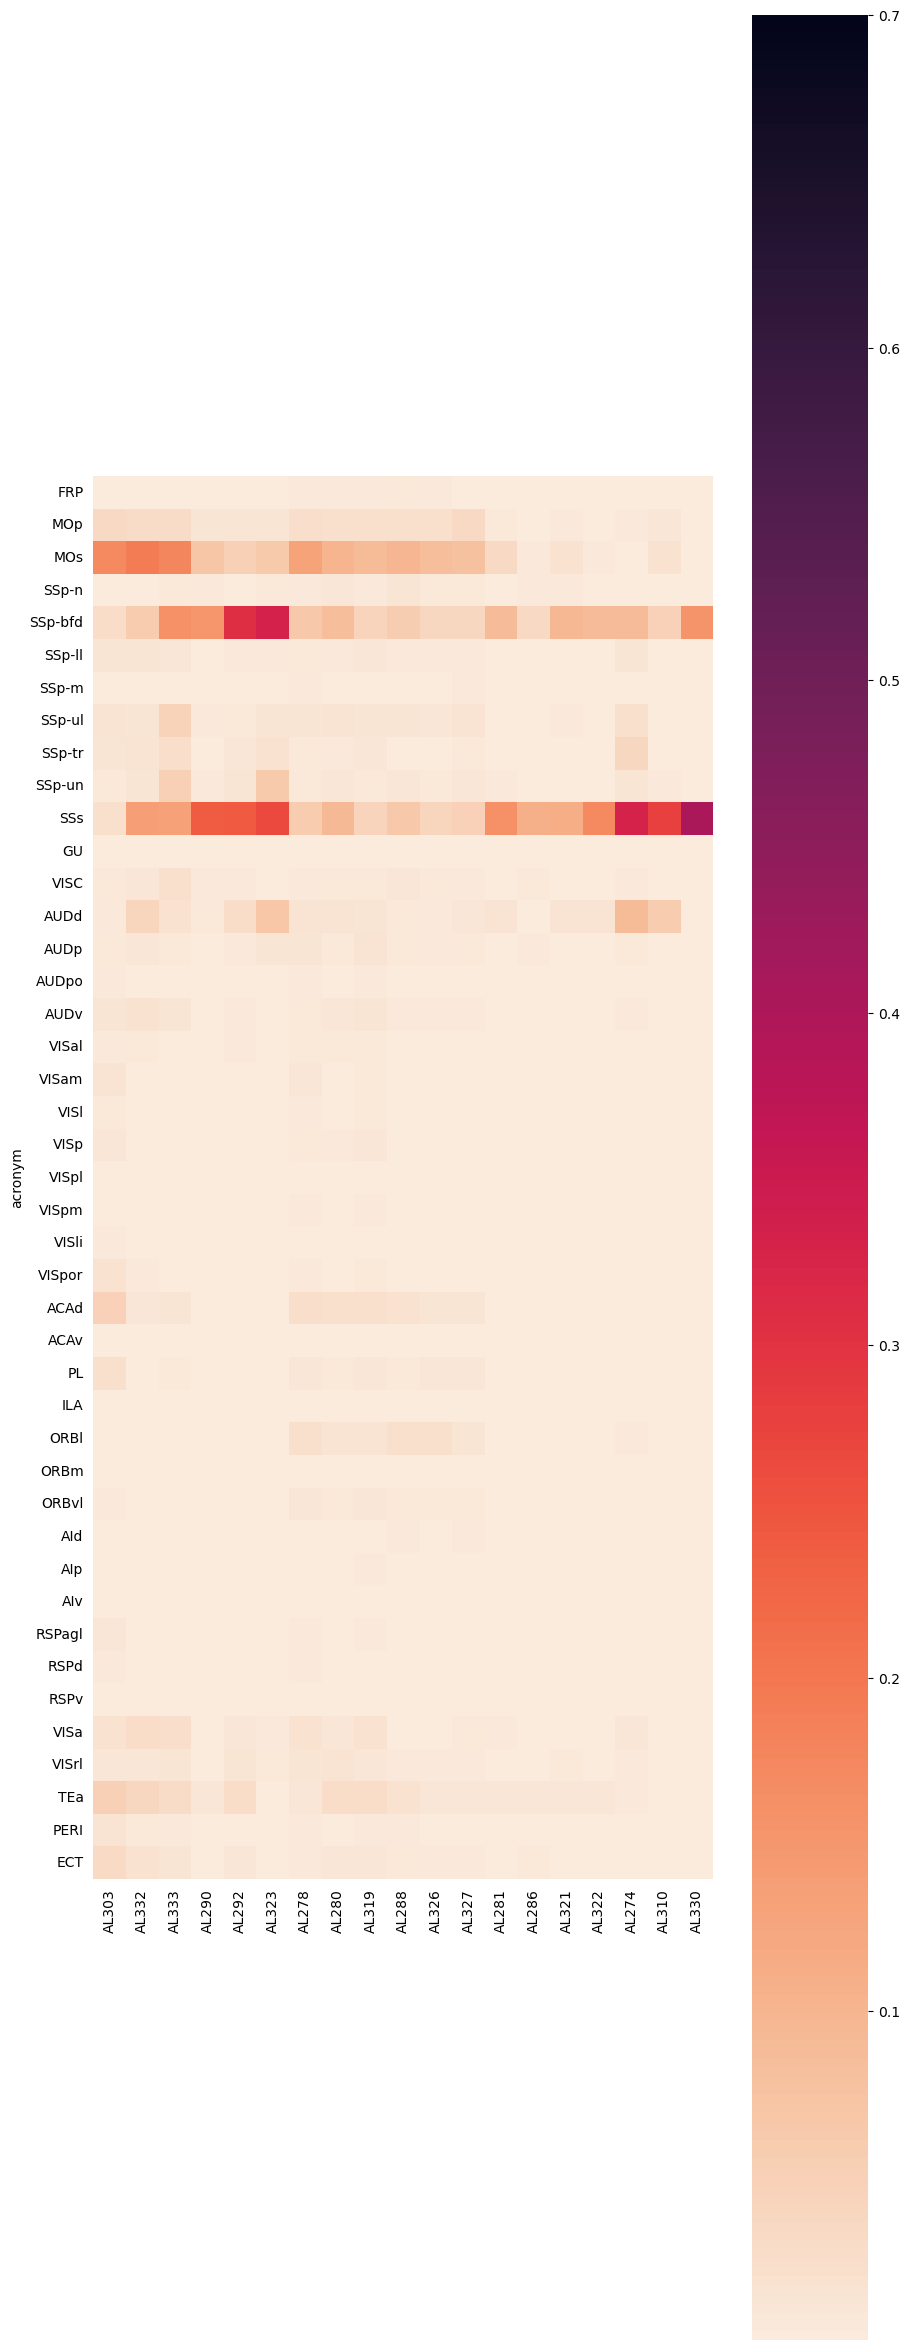

In [38]:
# linear scale, do not change vmin and vmax, 0 and 0.7

fig, ax = plt.subplots(figsize=(10,80))
g1= sns.heatmap(final_df,
                cmap="rocket_r",
                vmin= 0.001,
                vmax=0.7, 
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\{side}_{region_id}_heatmap_linearscale.svg')

plt.show()

### plotting correlation matrix with sns

In [3]:
indir= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

In [4]:
column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314',
               'AL211', 'AL215','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of april .2023

#column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327',
#             'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [5]:
axons_L= [ i for i  in os.listdir(indir) if 'axon_left' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axonal_df_L=axonal_df_L.T

axonal_df_L_ordered=axonal_df_L[column_order]
#order



In [6]:
axons_R= [ i for i  in os.listdir(indir) if 'axon_right' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

axonal_df_R=axonal_df_R.T

axonal_df_R_ordered=axonal_df_R[column_order]
#order

#axonal_df_R_ordered['AL310'][0]=0.00000
# No need to do this if plotting the full correlation (both hemispheres), only do this for plotting right hemisphere correlaiton
# because some brains(such as AL285) have nothing at all in the right hemisphere, correlation will show up as NAN and hence a blank row/column in heatmap
# just assign 1 to a random item so this does not happen

In [7]:
right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

In [8]:
full_df=pd.concat([axonal_df_L,axonal_df_R])
full_df=full_df[column_order]
#full_df

In [9]:
full_corr=full_df.corr()


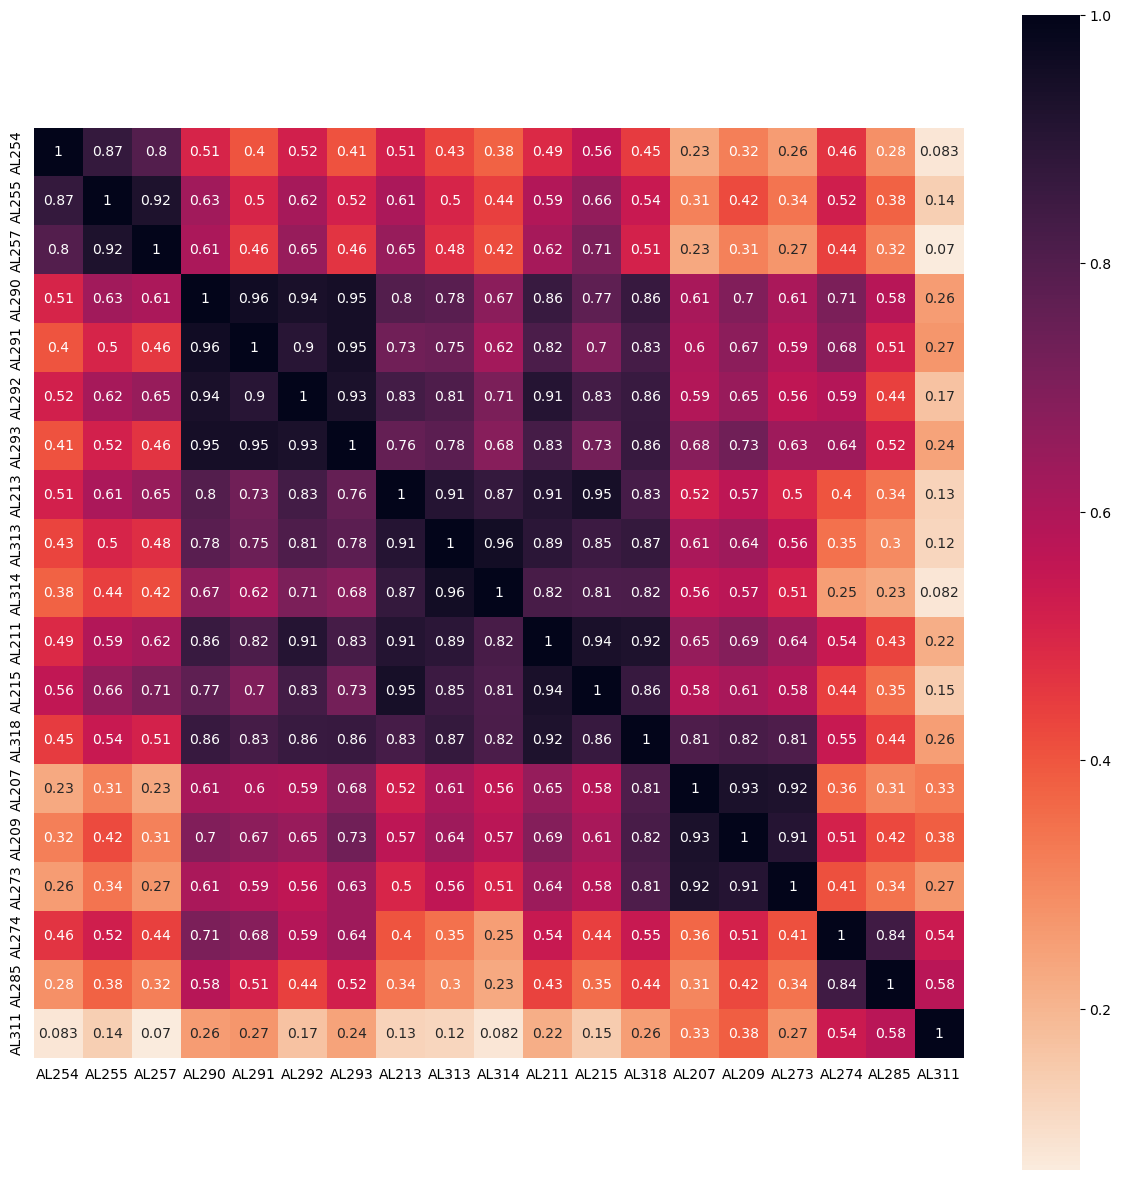

In [10]:

fig, ax = plt.subplots(figsize=(15,15))
g1=sns.heatmap(full_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\full_correlation.svg')
plt.show()

### Section for big regions- depth 3 and 4 
Plot axons in broad groups as overview first

involved regions:

    '/695/', cortical plate
    '/703/', cortical subplate
    '/477/', striatum
    '/803/', pallidum
    '/549/', thalamus
    '/1097/', hypothalamus
    '/339/', midrbain sensory related
    '/323/', midbrain motor related
    '/348/, midbrain behavioral state related
    '/771/', pons
    '/354/', medulla
    '/528/', cerebellar cortex
    '/519/', cerebellar nuclei


In [99]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def sum_broad_group (df,sample_list, broad_group):
    '''from data frame, group structures by bigger regions, ie. cortical plate, cortical subplate, etc '''
        
    all_region=pd.DataFrame()

    for i in broad_group: 
        region_id= i
        choosen_regions= df.loc[df['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

        this_region= atlas_labels[atlas_labels['id']==i]

        region_sum= []
        for j in sample_list:
            region_sum.append (choosen_regions[j].sum())

        this_region[sample_list]= region_sum
        this_region['sum']= sum(region_sum)

        all_region= pd.concat([all_region, this_region])
    
    return all_region


def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1, df2])
    both_df=both_df.reset_index()

    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it

    side_column= both_df.pop('side')
    both_df.insert(2, "side", side_column, allow_duplicates=False)

    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[3:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-3
    # need to repeat injection site list for x times, minus the index column, the site column, and the side column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1

    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region


    repeated_list_side=[]
    y=0
    while y<to_repeat:
        repeated_list_side.append(both_df['side'].to_list())
        y+=1

    new_list_side = itertools.chain(*repeated_list_side)
    new_list_side=list(new_list_side)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    expand1['side']= new_list_side
# finally add the injection site information as a column
    
    return expand1

def grouped_bar(expanded_df):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,10))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.5),
    )

    ax.set(xlim=(0, 0.9))
    # use the same x range for all plots
    
    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\\{mouseline}_avg_big.svg')

    plt.show()


In [109]:
broad_group= [695, 703, 477, 803, 549, 1097, 339, 323, 348, 771, 354, 528, 519]
# plot data in broader groups

#broad_group= [315, 698, 1089]
# these are the regions within coprtical plate 695
# isocortex 315, olfactory areas 698, and hippocampal formation 1089


In [110]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

outdir= r'D:\\viral_results\\s1_s2'

mouseline='tlx'
# could be ras, scn, tlx, sim, rbp, or nts
# change manually and run the following cells in the region

In [111]:
side='left'
# could be left or right

region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

df1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
df2= extract_df(name_list2,big_df2, region2)
# do the same for s2

df2['side']= side
df1['side']= side

expanded_left= combine_expanddf(df1,df2)
# combine the two dfs

In [112]:
side='right'
# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

name_list1=find_sample_list(read_file)
#find the list of involved sample

big_df1= sum_broad_group (read_file,name_list1, broad_group)
# sum up regions that belong to the same broad group

df1= extract_df(name_list1,big_df1, region)
# extract only the useful informations

name_list2=find_sample_list(read_file2)
big_df2= sum_broad_group (read_file2,name_list2, broad_group)
df2= extract_df(name_list2,big_df2, region2)
# do the same for s2

df2['side']=side
df1['side']=side

expanded_right= combine_expanddf(df1,df2)

right_acronym= [i+'_r' for i in expanded_right['acronym']]
expanded_right['acronym']=right_acronym
# add identifier for the right hemisphere

expanded_both= pd.concat([expanded_left,expanded_right])
expanded_both=expanded_both.sort_values(by=['acronym'])
# sort by acronym so a given region from left and right are ordered together

In [113]:
expanded_both= pd.concat([expanded_left,expanded_right])
expanded_both=expanded_both.sort_values(by=['site','acronym'])
# sort by acronym so a given region from left and right are ordered together
# sort by site first so that s1 is red and s2 is blue..consistent with other bar plots

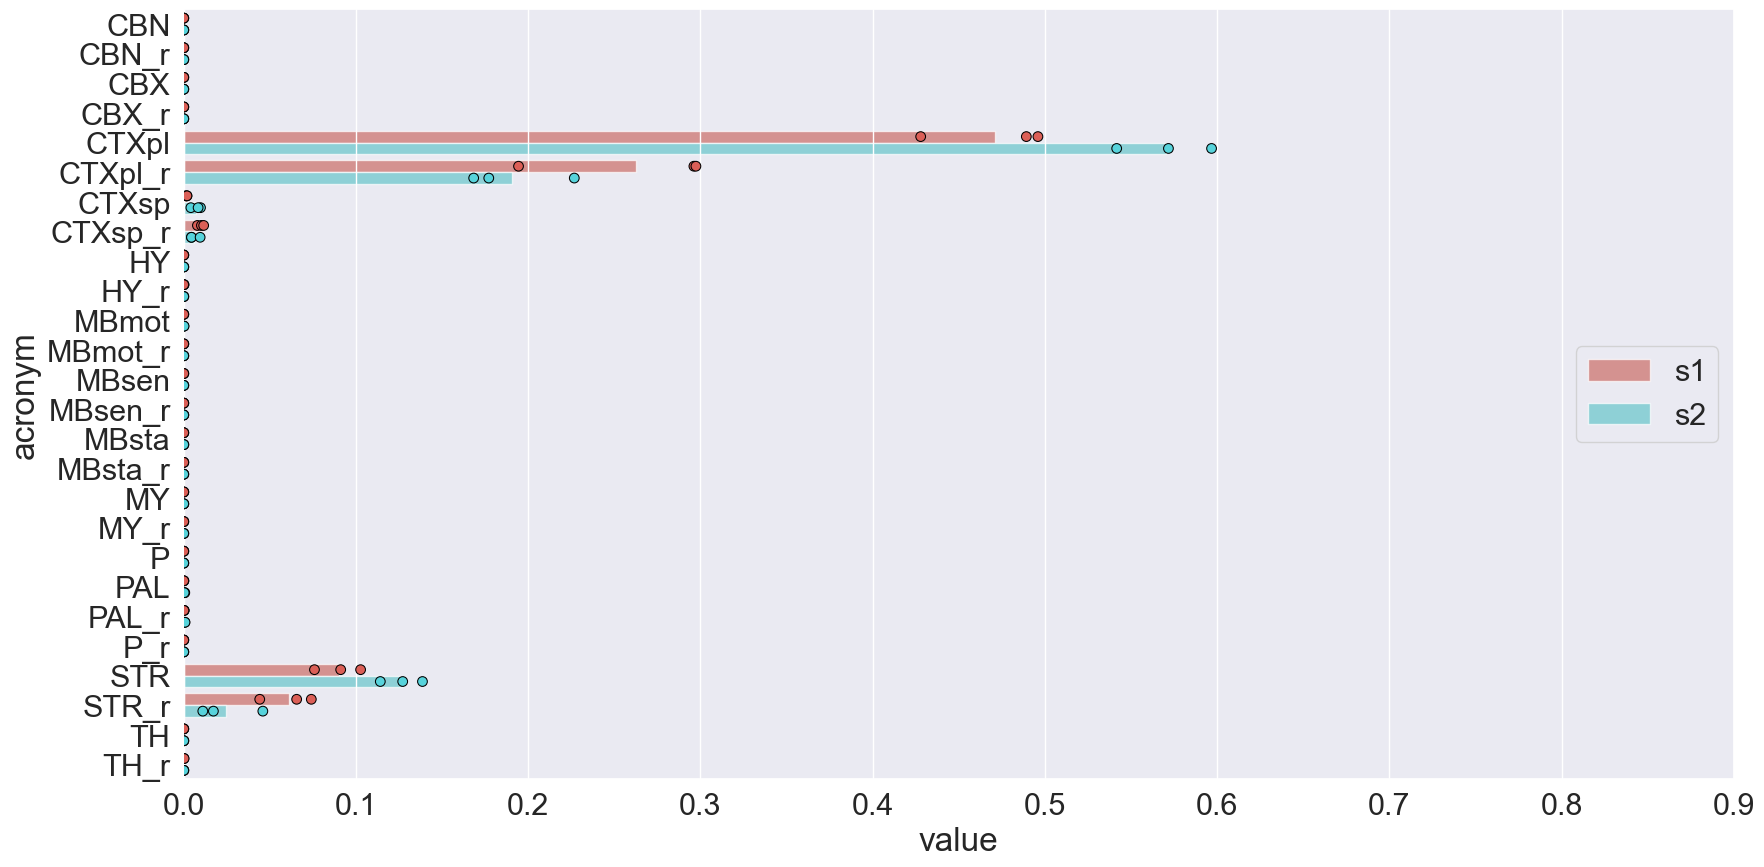

In [114]:
grouped_bar(expanded_both)

### section to plot bar graphs- a given region for s1 vs s2 comparison

layers combined!

some ids to consider

isocortex 315

    Frontal pole 184
    somatomotor areas 500
    somatosensory areas 453
    gustatory area 1057
    visceral area 677
    auditory areas 247
    visual areas 669
    anterior cingulate area 31
    prelimbic area 972
    infralimbic area 44
    orbital area 714
    agranular insula 95
    retrosplenial area 254
    posterior association areas 22
    Temporal association area 541
    perirhinal area 922
    ectorhinal area 895

In [84]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def prepare_parent(df, sample_list):
    test=df.groupby(['parent_structure_id'],as_index=False).sum()
    # group each region based on parent structure id so that layers are combined and values summed

    parent_structureid= test.pop('parent_structure_id')
    # store the parent structure id and remove it from the df
    #test['id']=parent_structureid
    # now the id of each acronym is its parent id

    extract_sample=test[sample_list]
    # extract only the sample names and assign to new data frame
    extract_sample['id']=parent_structureid
    # add the id to this new data frame so next we can merge with atlas label

    result = pd.merge(extract_sample, atlas_labels, on=["id"])
    # merge with atlas label on id, now all information is true such that we can do further grouping, ordering, etc based on this data frame
    
    return result
    
def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1, df2])
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1


def grouped_bar(expanded_df):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(20,40))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!
    
    plt.savefig(f'{outdir}\\{mouseline}_avg_{side}_{region_id}_parent.svg')

    plt.show()

In [162]:
outdir= r'D:\\viral_results\\s1_s2'

mouseline='nts'
# could be ras, scn, tlx, sim, rbp, or nts
side='right'
# could be left or right

# read in the two data frames. these xlsx files are output of the section above 'Generate excel files for averaged brains based on excel file of each sample'
region='s1'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{mouseline}_avg_{side}.xlsx'
read_file= pd.read_excel(file_path)
#read_file['injection']=region

region2='s2'
file_path2= f'D:\\viral_results\\{region2}_results\\{region2}_{mouseline}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path2)
#read_file2['injection']=region2

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')


list of brains involved for each genotype
now extracted automatically through function find_sample_list

#ras list

s1_list=['AL254', 'AL255','AL257']
s2_list= ['AL303', 'AL332','AL333']


#scn list

s1_list=['AL290','AL291','AL292','AL293']
s2_list= ['AL290','AL292','AL323']


#tlx list
s1_list=['AL213','AL313','AL314']
s2_list= ['AL278','AL280','AL319']

#sim list

s1_list=['AL207','AL209','AL273']
s2_list=['AL281','AL286','AL321','AL322']

#rbp list

s1_list= ['AL211','AL215','AL318']
s2_list= ['AL288','AL326','AL327']

#nts list

s1_list= ['AL274','AL285','AL311']
s2_list= ['AL274','AL310','AL330']

In [163]:
# how about only keeping the relevant info and re arrange data frame
region_id='315'
choosen_regions= read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]

choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for s2
choosen_regions2= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2= choosen_regions2.sort_values('graph_order', ascending=True)


In [164]:
s1_list=find_sample_list(choosen_regions)
s1_parent= prepare_parent(choosen_regions, s1_list)

s2_list=find_sample_list(choosen_regions2)
s2_parent= prepare_parent(choosen_regions2, s2_list)

# sum up values across layers for each region

In [165]:
#s1_list=find_sample_list(choosen_regions)
s1_df= extract_df(s1_list, s1_parent,'s1')

#s2_list=find_sample_list(choosen_regions2)
s2_df= extract_df(s2_list, s2_parent,'s2')


In [166]:
expanded= combine_expanddf(s1_df,s2_df)
expanded.fillna(0, inplace=True)

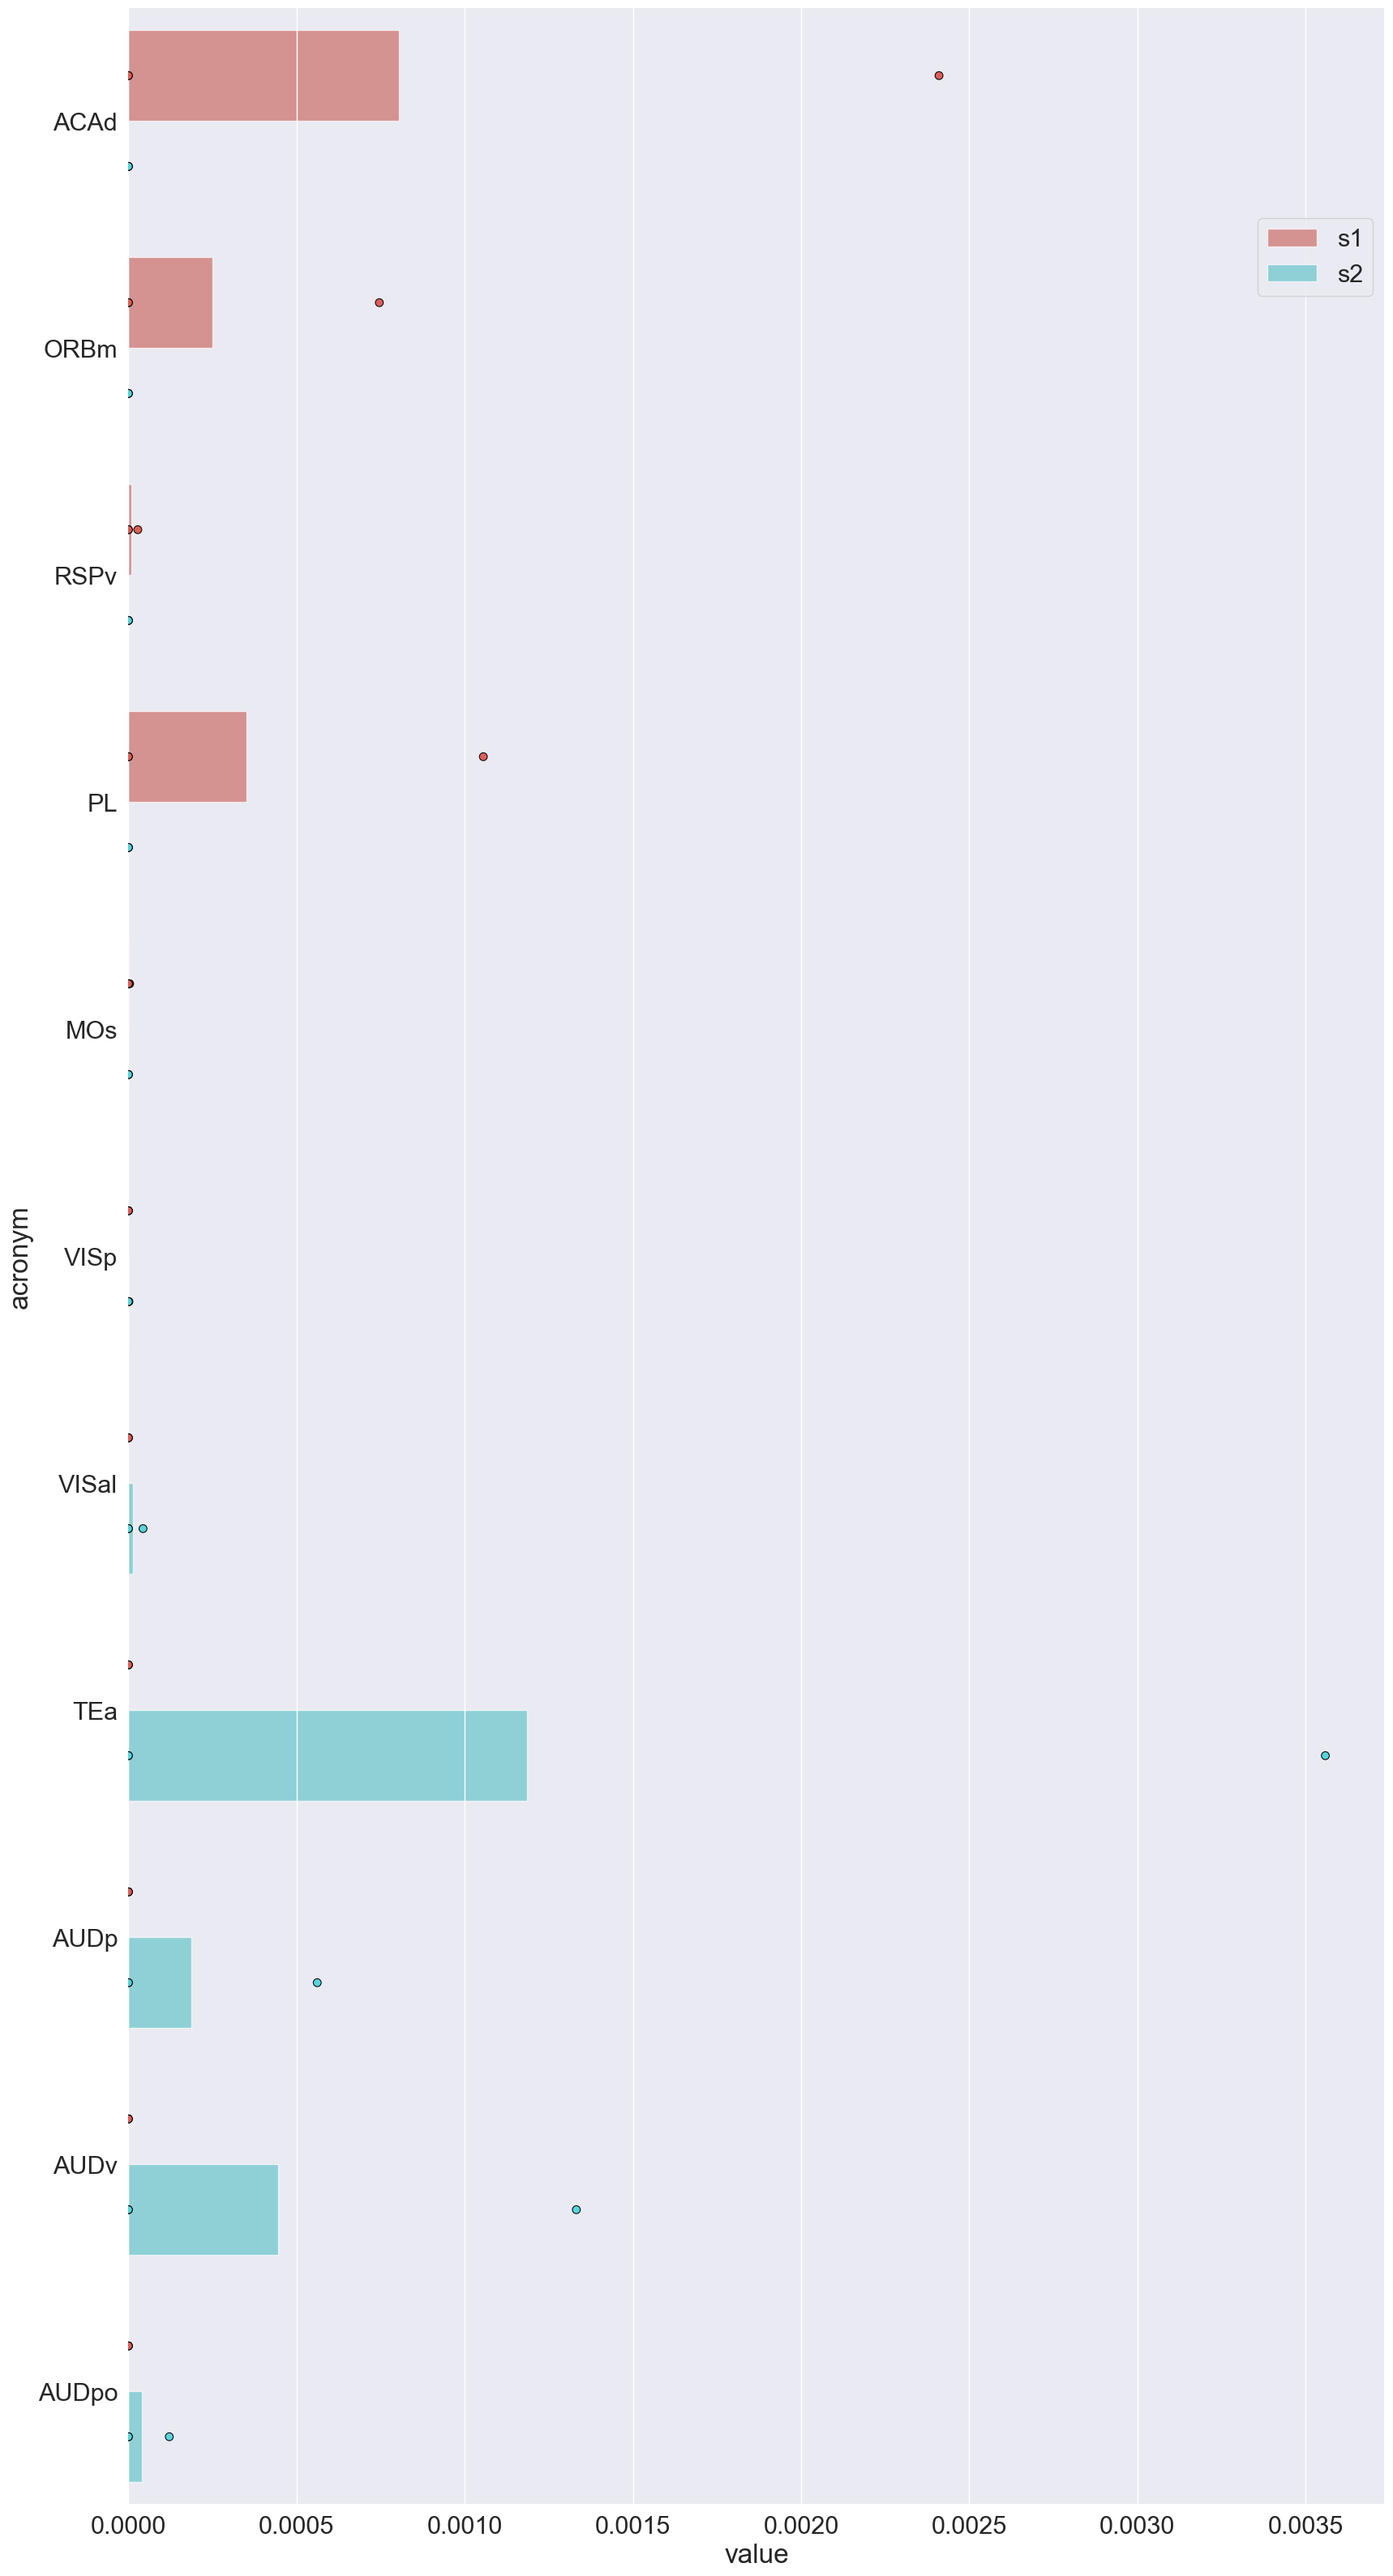

In [167]:
grouped_bar(expanded)

In [168]:
### test section for t test

both_df= pd.concat([s1_df, s2_df])
both_df=both_df.reset_index()
# combine the two df from s1 and s2 first

site_column= both_df.pop('site')
both_df.insert(1, "site", site_column, allow_duplicates=False)
# always make sure that the first column is index and secon column is injection site


In [169]:
from scipy.stats import ttest_ind

s1 = both_df[both_df['site']=='s1']
s2 = both_df[both_df['site']=='s2']

class1=pd.to_numeric(s1['MOs'])
class2=pd.to_numeric(s2['MOs'])

ttest_ind(class1, class2, equal_var=False)

Ttest_indResult(statistic=nan, pvalue=nan)

In [170]:
f=open(f'{outdir}\\{mouseline}_avg_{side}_{region_id}_parent.txt','w+')


for i in both_df.columns[2:]:
    # extract all acronyms, skips the first column which is the index(sample name) and second column which is the injection site
    
    class1=pd.to_numeric(s1[i])
    class2=pd.to_numeric(s2[i])

    stats,pvalue= ttest_ind(class1, class2, equal_var=False)
        
    if pvalue< 0.05:
        print(f'{i}, p value = {pvalue}')
        f.write(f'{i}, p value = {pvalue} \n')
    else:
        pass

f.close()
    

### section to plot bar graphs- a givne region for one injection site for all lines

work in progress, must normalize each layer to total amount of axon within the region ( ie, layers 1 to 6 within SSp-bfd adds up to 1)
Cannot just simply plot their value as fraction of total axons in the brain


Ok need to normalize each layer within each region first 
ie. All layer in MOs should add up to one

strategy- loop through every name with a number would indicate a region 's layer, go to one depth up, find the atlas id
then unique this list to get all the region that have layer 
loop through this list to sum up its sublayers, divide all the layer within with this um


In [11]:
def find_sample_list(df):
    '''Find list of sample's name from datafame column, ie: AL254, AL255, AL256'''
    sample_list= []

    for i in df.columns:
        m=re.search('\D{2}[0-9]{3}', i)
        if m: 
            sample_list.append(m[0])
    
    return sample_list

def normalize_layers (df, samples_list):
    sum_parent=df.groupby(['parent_structure_id'],as_index=False).sum()
    # compute sum of the parent regions
    
    parent_df= sum_parent[samples_list]
    parent_df['id']= sum_parent['parent_structure_id']
    # store the sums for each corresponding sample and their parent id
    
    normalized_df=[]

    for i in parent_df.id:
        this_parent= parent_df[parent_df['id']==i]
        # find the corresponding denominator

        this_child= df[df['parent_structure_id']== i]
        #find the corresponding numerators

        fraction_df= this_child/ this_parent.iloc[0]
        # this_parent.iloc[0] for format conversion to series so we could devide
        this_fraction= fraction_df[samples_list]
        this_fraction['id']=this_child['id']

        normalized_df.append(this_fraction)

    # append separate df into list
    normalized_df=pd.concat(normalized_df)
    # concatenate the separate dfs, actually a briliiant way
    
    normalized_df_fullinfo= pd.merge(normalized_df,atlas_labels, on='id')
    #merge back with atlas labels to get full info
    
    return normalized_df_fullinfo


def extract_df(name_list,choosen_df, site):
    '''from data frame, extract only relevant information-> region acronyms and values from individual samples 
    then, insert injection site information (site = 's1' , or 's2')'''
    name_list.insert(0,'acronym')
    # insert acronym to the list to be used as extracting columns from df
    testdf=choosen_df[name_list]
    new=testdf.T
    #new

    new.columns =new.iloc[0]
    new=new.drop(new.index[0])
    # make the acronym row as column names, then drop the first row

    new['site']=site
    # add respective injection site info to each sample
    return new

def combine_expanddf (df1,df2,df3, df4, df5, df6):
    ''' combine two df , and prepare to sns barplot compatible format by pd.melt '''
    
    both_df= pd.concat([df1,df2,df3, df4, df5, df6])
    both_df=both_df.reset_index()
    
    site_column= both_df.pop('site')
    both_df.insert(1, "site", site_column, allow_duplicates=False)
    # some times the site column will not always be in the last position of column order after pd.concat, because some regions are not present in both averaged excel files
    # relocate the site column as the second in the column order(position 1) so in the next melt step we do not include it
    
    expand1=pd.melt(both_df, id_vars=['index'], value_vars=both_df.columns[2:])
    # melt into sns preferred format
    to_repeat=len(both_df.columns)-2
    # need to repeat injection site list for x times, minus the index column and the site column

    repeated_list=[]
    x=0
    while x<to_repeat:
        repeated_list.append(both_df['site'].to_list())
        x+=1
    
    new_list = itertools.chain(*repeated_list)
    new_list=list(new_list)
    len(new_list)
    # use itertool to flatten list of list, final length = number of sample * number of brain region

    expand1['site']= new_list
    # finally add the injection site information as a column
    
    return expand1

def grouped_bar(expanded_df,region_id):
    
    '''plot grouped bar plot + strip plot(for individual data points to show up on bar)
    for s1 vs s2 
    input: data frame with columns= index (sample identifier), acronym of region, value of axons, injection site for this sample. 
    Usually this data frame is the output of expand_df 
    '''

    sns.set(font_scale=2)

    fig, ax = plt.subplots(figsize=(10,15))

    # Draw the bar chart
    g1 = sns.barplot(
        data=expanded_df,
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        zorder=0,
        alpha=0.7, 
        errorbar=None,
    )

    g1.tick_params(bottom=False, left=False)
    # disable ticks because it is such a mess in illustrator!

    # Get the legend from just the bar chart
    handles, labels = g1.get_legend_handles_labels()

    # Draw the stripplot
    g2=sns.stripplot(
        data=expanded_df, 
        x='value',
        y='acronym',
        hue='site',
        palette="hls",
        orient="h", 
        size= 7,
        dodge=True, 
        jitter=False,
        edgecolor="black", 
        linewidth=.75,
        ax=ax,
    )

    # Remove the old legend
    g2.legend_.remove()
    # Add just the bar chart legend back
    ax.legend(
        handles,
        labels,
        loc='center right',
        bbox_to_anchor=(1, 0.9),
    )

    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!

    plt.savefig(f'{outdir}\\normalized_{region_id}.svg')

    plt.show()
    

In [17]:
#WORK IN PROGRESS

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

outdir= r'D:\\viral_results\\s1_s2'

region='s1'
side='left'
region_id='541'

# read in the two data frames
cre1='ras'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{cre1}_avg_{side}.xlsx'
read_file1= pd.read_excel(file_path)
read_file1['cre']=cre1

cre2='scn'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{cre2}_avg_{side}.xlsx'
read_file2= pd.read_excel(file_path)
read_file2['cre']=cre2

cre3='tlx'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{cre3}_avg_{side}.xlsx'
read_file3= pd.read_excel(file_path)
read_file3['cre']=cre1

cre4='sim'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{cre4}_avg_{side}.xlsx'
read_file4= pd.read_excel(file_path)
read_file4['cre']=cre1

cre5='rbp'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{cre5}_avg_{side}.xlsx'
read_file5= pd.read_excel(file_path)
read_file5['cre']=cre5

cre6='nts'
file_path= f'D:\\viral_results\\{region}_results\\{region}_{cre6}_avg_{side}.xlsx'
read_file6= pd.read_excel(file_path)
read_file6['cre']=cre6

In [18]:
choosen_regions= read_file1.loc[read_file1['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions= choosen_regions.sort_values('graph_order', ascending=True)
# sort based on the graph order so more related regions are together

# repeat the same for other cre lines
choosen_regions2= read_file2.loc[read_file2['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions2= choosen_regions2.sort_values('graph_order', ascending=True)

choosen_regions3= read_file3.loc[read_file3['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions3= choosen_regions3.sort_values('graph_order', ascending=True)

choosen_regions4= read_file4.loc[read_file4['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions4= choosen_regions4.sort_values('graph_order', ascending=True)

choosen_regions5= read_file5.loc[read_file5['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions5= choosen_regions5.sort_values('graph_order', ascending=True)

choosen_regions6= read_file6.loc[read_file6['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
choosen_regions6= choosen_regions6.sort_values('graph_order', ascending=True)

In [19]:
cre1_list=find_sample_list(choosen_regions)
cre1_norm= normalize_layers(choosen_regions,cre1_list)
cre1_df= extract_df(cre1_list, cre1_norm,cre1)

cre2_list=find_sample_list(choosen_regions2)
cre2_norm= normalize_layers(choosen_regions2,cre2_list)
cre2_df= extract_df(cre2_list, cre2_norm,cre2)

cre3_list=find_sample_list(choosen_regions3)
cre3_norm= normalize_layers(choosen_regions3,cre3_list)
cre3_df= extract_df(cre3_list, cre3_norm,cre3)

cre4_list=find_sample_list(choosen_regions4)
cre4_norm= normalize_layers(choosen_regions4,cre4_list)
cre4_df= extract_df(cre4_list, cre4_norm,cre4)

cre5_list=find_sample_list(choosen_regions5)
cre5_norm= normalize_layers(choosen_regions5,cre5_list)
cre5_df= extract_df(cre5_list, cre5_norm,cre5)

cre6_list=find_sample_list(choosen_regions6)
cre6_norm= normalize_layers(choosen_regions6,cre6_list)
cre6_df= extract_df(cre6_list, cre6_norm,cre6)

In [20]:
expanded= combine_expanddf(cre1_df,cre2_df,cre3_df,cre4_df,cre5_df,cre6_df)
#expanded.fillna(0, inplace=True)

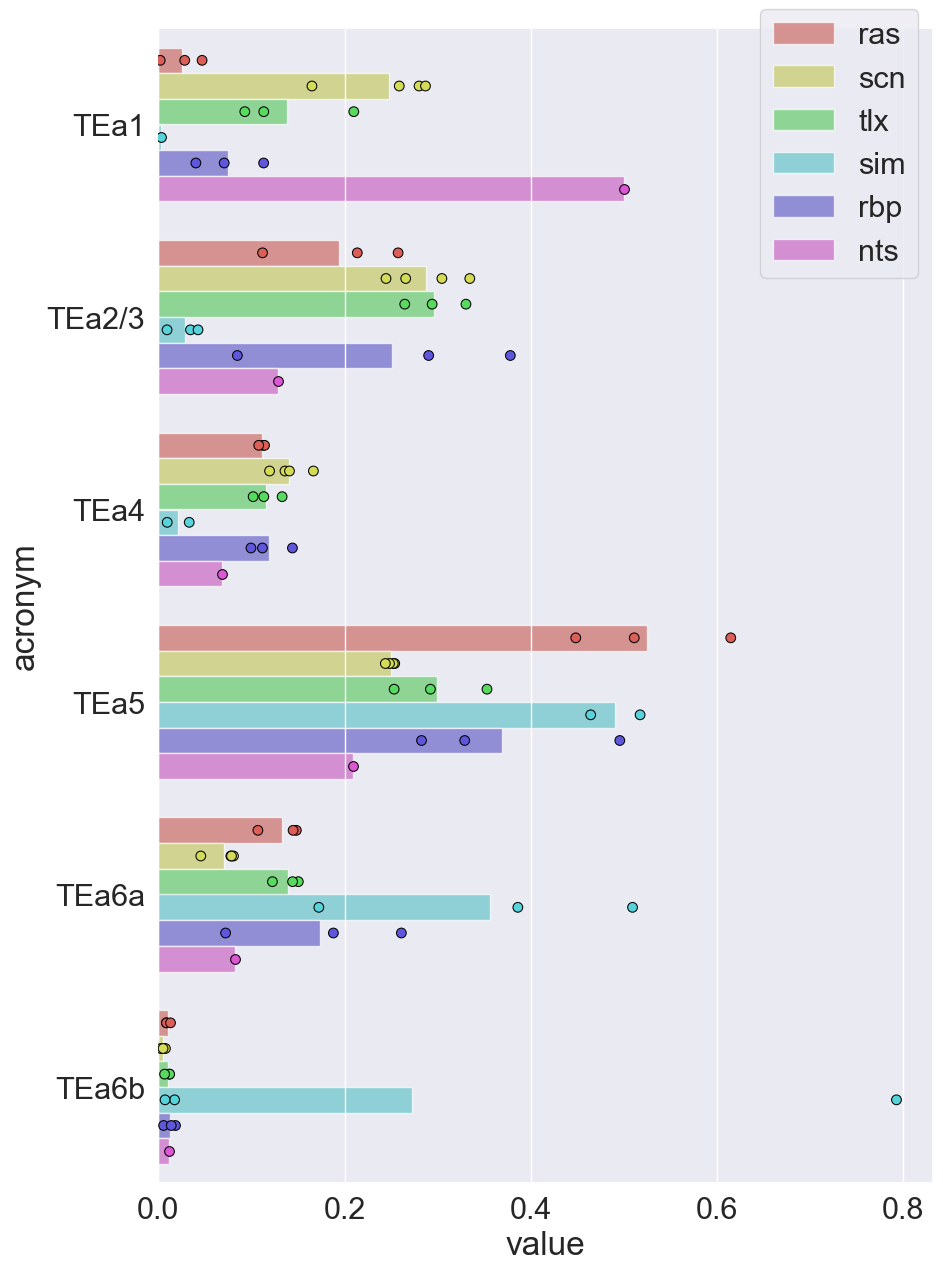

In [21]:
grouped_bar(expanded, region_id)

In [22]:
cre1_norm

,AL254,AL255,AL257,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
0,0.046966,0.001964,0.028306,97,1002.0,"Temporal association areas, layer 1",TEa1,11,1,3,...,361,/997/8/567/688/695/315/541/97/,15B0B3,NaN,NaN,f,362,456768453,734881840,Temporal association areas layer 1
1,0.213740,0.111945,0.257592,1127,706.0,"Temporal association areas, layer 2/3",TEa2/3,11,1,3,...,362,/997/8/567/688/695/315/541/1127/,15B0B3,NaN,NaN,f,363,74295275,734881840,Temporal association areas layer 2/3
2,0.112444,0.114075,0.107815,234,1019.0,"Temporal association areas, layer 4",TEa4,11,1,3,...,363,/997/8/567/688/695/315/541/234/,15B0B3,NaN,NaN,f,364,1800621898,734881840,Temporal association areas layer 4
3,0.511337,0.615049,0.448493,289,1026.0,"Temporal association areas, layer 5",TEa5,11,1,3,...,364,/997/8/567/688/695/315/541/289/,15B0B3,NaN,NaN,f,365,475299804,734881840,Temporal association areas layer 5
4,0.106926,0.148233,0.144757,729,1081.0,"Temporal association areas, layer 6a",TEa6a,11,1,3,...,365,/997/8/567/688/695/315/541/729/,15B0B3,NaN,NaN,f,366,1289955072,734881840,Temporal association areas layer 6a
5,0.008587,0.008734,0.013038,786,1088.0,"Temporal association areas, layer 6b",TEa6b,11,1,3,...,366,/997/8/567/688/695/315/541/786/,15B0B3,NaN,NaN,f,367,3588912826,734881840,Temporal association areas layer 6b


### test region

[-0.17377256  1.56899161 -0.00825274  0.23547782]


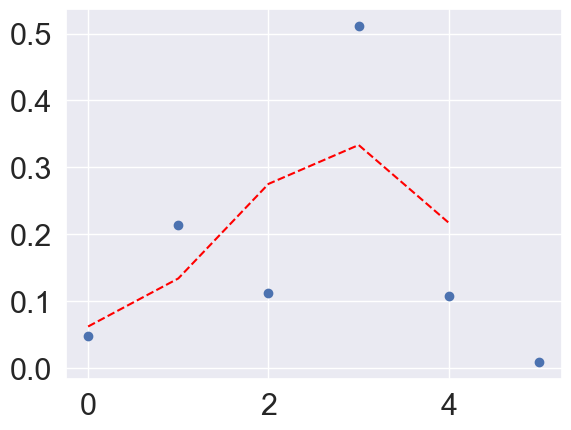

In [28]:
# curve fitting for layer distribution test

from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

# define the true objective function
def objective(x, a, b, c, d):
 return a * sin(b - x) + c * x**2 + d
 
# load the dataset
x, y = cre1_norm.index, cre1_norm['AL254']

# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d = popt
print(popt)
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c, d)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

# OK not so good, since only have 6 data points (6 layers)

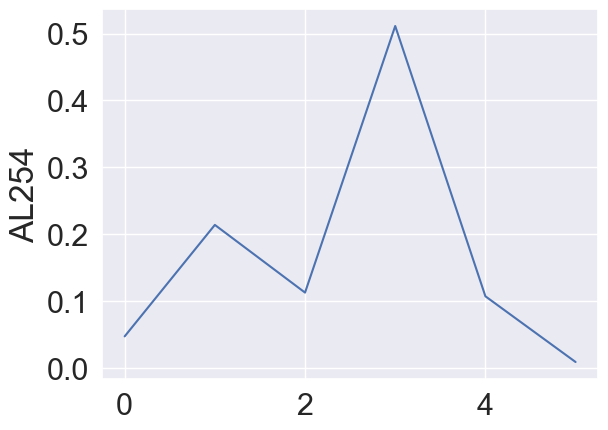

In [29]:
x, y = cre1_norm.index, cre1_norm['AL254']

sns.lineplot( x=x, y=y)   
plt.show()

### test section for hierarchical clustering

In [31]:
#final_df=final_df.rename(columns={'AL254': "ras1", 'AL255': "ras2", 'AL257': "ras3",
                         'AL290': "scn1", 'AL291': "scn2", 'AL292': "scn3",'AL293': "scn4",
                         'AL213': "tlx1", 'AL313': "tlx2", 'AL314': "tlx3",
                         'AL211': "rbp1", 'AL215': "rbp1", 'AL318': "rbp1",
                         'AL207': "sim1", 'AL209': "sim2", 'AL273': "sim3",
                         'AL274': "nts1", 'AL285': "nts2", 'AL311': "nts3",
                        })

#rearrange columns for sns.clustermap since it always wants to arrange columns in a weird way


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\seaborn\matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


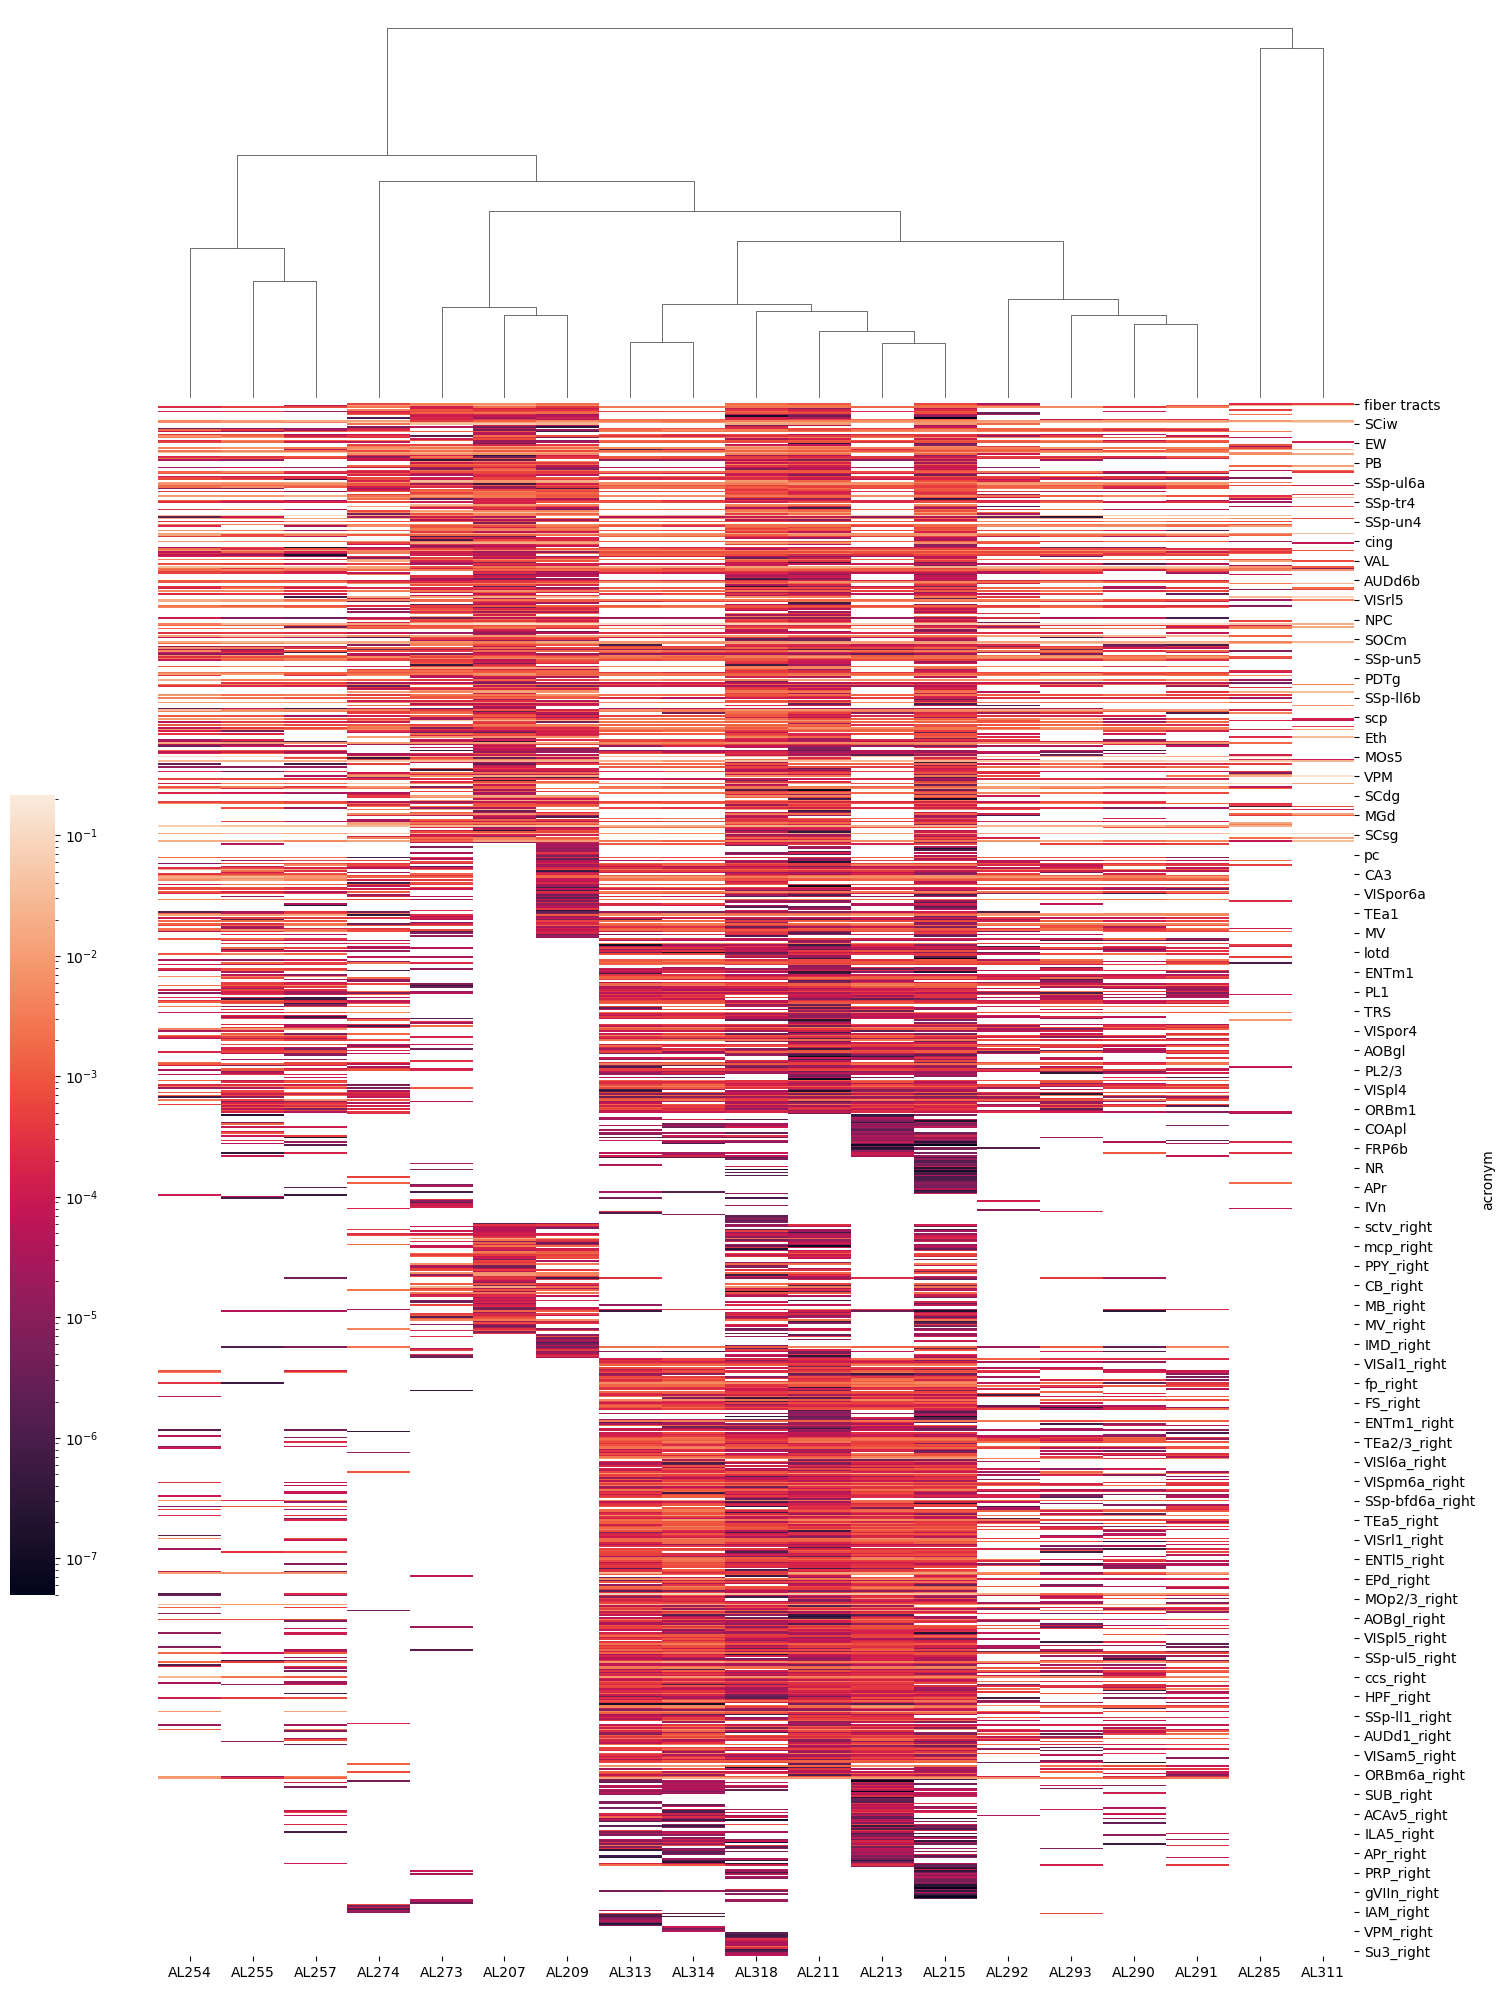

In [12]:
sns.clustermap(
    full_df,
    figsize=(15, 20),
    norm=LogNorm(),
    row_cluster=False,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(0, .2, .03, .4)
)

WORK IN PROGRESS
# still in a weird way after rearrangement,...need to look up